# 1.Import de Librerías

In [1]:
# Standard library imports
import os
import subprocess
from datetime import date

# Third-party library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

# PySpark imports
from pyspark import SparkContext, HiveContext
from pyspark.sql import DataFrame, SQLContext, SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import TimestampType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)


def missing_values_summary(df):
    # Columnas numéricas
    numeric_columns = [c for c, t in df.dtypes if t in ["double", "float"]]

    # Columnas no numéricas
    other_columns = [c for c, t in df.dtypes if t not in ["double", "float"]]

    # Contar valores faltantes para columnas numéricas
    numeric_missing = [
        F.count(F.when(F.isnan(F.col(c)) | F.col(c).isNull(), c)).alias(c)
        for c in numeric_columns
    ]

    # Contar valores faltantes para columnas no numéricas
    other_missing = [
        F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in other_columns
    ]

    # Combinar resultados de valores faltantes
    missings_df = df.select(numeric_missing + other_missing).toPandas()

    # Calcular el porcentaje y reformatear como DataFrame
    total_rows = df.count()
    summary = []

    for col_name in missings_df.columns:
        count_missing = missings_df.at[0, col_name]
        percentage_missing = (count_missing / total_rows) * 100
        summary.append(
            {
                "feature": col_name,
                "count": count_missing,
                "%": round(percentage_missing, 2),
            }
        )

    return pd.DataFrame(summary)


def plot_histogram(data, column_name, num_bins=30):
    """
    Genera un histograma de la columna especificada de un DataFrame de PySpark.

    :param data: DataFrame de PySpark que contiene los datos.
    :param column_name: Nombre de la columna a analizar.
    :param num_bins: Número de bins para el histograma.
    """
    # Obtener valores mínimo y máximo de la columna
    min_value = data.agg(F.min(column_name)).first()[0]
    max_value = data.agg(F.max(column_name)).first()[0]

    # Calcular el ancho de los bins y los límites
    bin_width = (max_value - min_value) / num_bins
    bins = [min_value + i * bin_width for i in range(num_bins + 1)]

    # Crear la expresión para determinar el bin
    bin_expr = F.when(
        F.col(column_name) < bins[0], None
    )  # Caso para valores menores al mínimo
    for i in range(num_bins):
        bin_expr = bin_expr.when(
            (F.col(column_name) >= bins[i]) & (F.col(column_name) < bins[i + 1]),
            bins[i],
        )
    bin_expr = bin_expr.otherwise(bins[-2])  # Caso para el valor máximo

    # Añadir la columna con el bin correspondiente
    data_with_bins = data.withColumn("bin_start", bin_expr)

    # Eliminar filas donde no hay un bin asignado (valores fuera del rango)
    data_with_bins = data_with_bins.dropna(subset=["bin_start"])

    # Contar las ocurrencias en cada bin
    hist_counts = data_with_bins.groupBy("bin_start").count().orderBy("bin_start")

    # Convertir a pandas para graficar
    hist_counts_pd = hist_counts.toPandas()

    # Crear el histograma usando Matplotlib
    plt.figure(figsize=(10, 6))
    plt.bar(
        hist_counts_pd["bin_start"],
        hist_counts_pd["count"],
        width=bin_width,
        color="blue",
        alpha=0.7,
        align="edge",
    )
    plt.title(f"Histograma de {column_name}")
    plt.xlabel(f"{column_name} (Inicio del Bin)")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45)
    plt.grid(axis="y", alpha=0.75)
    plt.show()


def create_box_plot(df, column_name):
    """
    Crea un gráfico de caja a partir de un DataFrame de PySpark y una columna específica.

    Args:
        df (DataFrame): DataFrame de PySpark que contiene los datos.
        column_name (str): Nombre de la columna para la que se generará el gráfico de caja.
    """
    # Calcular estadísticas del box plot
    box_plot_stats = df.select(
        F.percentile_approx(column_name, 0.25).alias("Q1"),
        F.percentile_approx(column_name, 0.5).alias("Median"),
        F.percentile_approx(column_name, 0.75).alias("Q3"),
        F.min(column_name).alias("Min"),
        F.max(column_name).alias("Max"),
    ).first()

    # Convertir las estadísticas a un DataFrame de pandas
    box_plot_df = pd.DataFrame(
        {
            "Stat": ["Min", "Q1", "Median", "Q3", "Max"],
            "Value": [
                box_plot_stats["Min"],
                box_plot_stats["Q1"],
                box_plot_stats["Median"],
                box_plot_stats["Q3"],
                box_plot_stats["Max"],
            ],
        }
    )

    # Crear el gráfico de caja
    plt.figure(figsize=(8, 6))
    plt.boxplot(box_plot_df["Value"], labels=[column_name])
    plt.title(f"Box Plot de {column_name}")
    plt.ylabel("Seconds")
    plt.grid(axis="y")
    plt.show()


def calculate_trip_seconds_percentiles(df, column_name):
    # Definir los percentiles a calcular
    percentiles = [x / 10 for x in range(1, 10)] + [0.01, 0.02, 0.03, 0.97, 0.98, 0.99]

    # Calcular estadísticas descriptivas para la columna especificada
    trip_seconds_stats = df.approxQuantile(column_name, percentiles, 0.01)

    # Convertir a un DataFrame de pandas para facilitar la visualización
    trip_seconds_df = pd.DataFrame(
        {"Percentiles": percentiles, "Trip Seconds": trip_seconds_stats}
    )

    # Ordenar por percentiles
    trip_seconds_df = trip_seconds_df.sort_values("Percentiles").reset_index(drop=True)

    return trip_seconds_df


def create_boxplot(df_spark, columns, title="Boxplot", figsize=(12, 8)):
    # Calcular estadísticas para las columnas especificadas
    box_plot_stats = df_spark.select(
        [F.percentile_approx(col, 0.25).alias(f"{col}_Q1") for col in columns]
        + [F.percentile_approx(col, 0.5).alias(f"{col}_Median") for col in columns]
        + [F.percentile_approx(col, 0.75).alias(f"{col}_Q3") for col in columns]
        + [F.min(col).alias(f"{col}_Min") for col in columns]
        + [F.max(col).alias(f"{col}_Max") for col in columns]
    ).first()

    box_plot_data = {**{col: [] for col in columns}}

    for col in columns:
        box_plot_data[col].extend(
            [
                box_plot_stats[f"{col}_Min"],
                box_plot_stats[f"{col}_Q1"],
                box_plot_stats[f"{col}_Median"],
                box_plot_stats[f"{col}_Q3"],
                box_plot_stats[f"{col}_Max"],
            ]
        )

    box_plot_df = pd.DataFrame(box_plot_data)
    melted_df = box_plot_df.melt(var_name="Variable", value_name="Value")

    # Configurar el tamaño de la figura
    plt.figure(figsize=figsize)
    sns.boxplot(
        data=melted_df,
        x="Value",
        y="Variable",
        hue="Variable",
        palette="Set2",
        legend=False,
    )
    plt.xlabel("Valor")
    plt.title(title)
    plt.grid(True)
    plt.show()


def calculate_outliers(df, column):
    # Calcular Q1 y Q3
    q1 = df.approxQuantile(column, [0.25], 0.01)[0]
    q3 = df.approxQuantile(column, [0.75], 0.01)[0]

    # Calcular IQR
    iqr = q3 - q1

    # Calcular límites inferior y superior
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Identificar outliers
    outliers = df.filter((F.col(column) < lower_bound) | (F.col(column) > upper_bound))

    # Contar outliers
    conteo_outliers = outliers.count()

    # Calcular el total de datos
    total_datos = df.count()

    # Calcular el porcentaje de outliers
    porcentaje_outliers = round(
        (conteo_outliers / total_datos) * 100 if total_datos > 0 else 0, 2
    )

    print(f"Cantidad de outliers: {conteo_outliers:,}")
    print(f"Porcentaje de outliers: {porcentaje_outliers:,} %")

    return lower_bound, upper_bound


def calculate_and_print_percentiles(
    df: DataFrame,
    column: str,
    probabilities: list = [0.97, 0.98, 0.9997, 0.9998, 0.9999],
    relative_error: float = 0.01):
    # Calcular percentiles
    percentiles = df.approxQuantile(column, probabilities, relative_error)
    
    # Imprimir resultados
    print(f"Percentiles específicos de '{column}':")
    for p, value in zip(probabilities, percentiles):
        print(f"Percentil {p:.4f}: {value}")

        
def plot_correlation_matrix(correlation_matrix, title="Matriz de Correlación", cmap="coolwarm", figsize=(8, 6), annot=True):
    # Crear el gráfico
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, 
                annot=annot, 
                cmap=cmap, 
                fmt=".2f", 
                square=True)
    plt.title(title)
    plt.show()
    

def get_value_proportions(df, group_columns):
    # Contar las ocurrencias de cada combinación de valores
    value_counts = df.groupBy(group_columns).count()

    # Calcular la proporción
    total_counts = df.count()
    value_proportions = value_counts.withColumn('Proportion', value_counts['count'] / total_counts)

    return value_proportions

In [2]:
ss = SparkSession.builder.appName("bigdatita").getOrCreate()

24/12/21 01:41:58 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


**2. Lectura de los archivos**

In [3]:
ruta = "/user/bigdatita/"
cmd = f"hdfs dfs -ls {ruta}"
lst = str(subprocess.check_output(cmd, shell=True)).strip().split("\\n")
lst = [x.split(" ")[-1] for x in lst]
lst = ["hdfs://%s" % x for x in lst if x != "items" if x != "'"]
lst

['hdfs:///user/bigdatita/taxi_trips_2023.csv',
 'hdfs:///user/bigdatita/taxi_trips_2024.csv']

**3. Lectura de archivos desde HDFS a Spark**

In [4]:
%%time
for i, file in enumerate(lst):
    print(file)
    if i == 0:
        raw_df = ss.read.csv(file, header=True, inferSchema=False)
    else:
        raw_df = raw_df.union(ss.read.csv(file, header=True, inferSchema=False))

hdfs:///user/bigdatita/taxi_trips_2023.csv


hdfs:///user/bigdatita/taxi_trips_2024.csv
CPU times: user 8.63 ms, sys: 4.13 ms, total: 12.8 ms
Wall time: 8.71 s


# 2. Pre procesamiento

## Trabajando con 10,000 elementos, quitar para trabajar con todo el modelo

In [5]:
df = raw_df.limit(10_000).repartition(2).cache()

In [6]:
date_format = "MM/dd/yyyy hh:mm:ss a"

df = df.withColumn(
    "Trip Start Timestamp",
    F.to_timestamp(df["Trip Start Timestamp"], date_format).cast(TimestampType()),
)
df = df.withColumn(
    "Trip End Timestamp",
    F.to_timestamp(df["Trip End Timestamp"], date_format).cast(TimestampType()),
)

df = df[(df["Trip Start Timestamp"] <= "2024-08-31")]

In [7]:
for var in ["Fare", "Tips", "Tolls", "Extras", "Trip Total", "Trip Miles"]:
    df = df.withColumn(var, df[var].cast("float"))

df = df.withColumn("Trip Seconds", F.col("Trip Seconds").cast("int"))

In [8]:
df.cache()

DataFrame[Trip ID: string, Taxi ID: string, Trip Start Timestamp: timestamp, Trip End Timestamp: timestamp, Trip Seconds: int, Trip Miles: float, Pickup Census Tract: string, Dropoff Census Tract: string, Pickup Community Area: string, Dropoff Community Area: string, Fare: float, Tips: float, Tolls: float, Extras: float, Trip Total: float, Payment Type: string, Company: string, Pickup Centroid Latitude: string, Pickup Centroid Longitude: string, Pickup Centroid Location: string, Dropoff Centroid Latitude: string, Dropoff Centroid Longitude: string, Dropoff Centroid  Location: string]

# 3. Análisis exploratorio de Datos (EDA)

In [9]:
subset = [
    "summary",
    "Trip Seconds",
    "Trip Miles",
    "Pickup Census Tract",
    "Dropoff Census Tract",
    "Pickup Community Area",
    "Dropoff Community Area",
    "Fare",
    "Tips",
    "Tolls",
    "Extras",
    "Trip Total",
    "Payment Type",
    "Company",
    "Pickup Centroid Latitude",
    "Pickup Centroid Longitude",
    "Pickup Centroid Location",
    "Dropoff Centroid Latitude",
    "Dropoff Centroid Longitude",
    "Dropoff Centroid  Location",
]

describe_df = df.describe().toPandas()
describe_df[subset].round(2)

24/12/21 01:42:13 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,count,9997,10000,3962,3987,9420,9263,9992,9992,9992,9992,9992,10000,10000,9420,9420,9420,9280,9280,9280
1,mean,1032.2461738521556,5.496808998105862,1.7031422899843765E10,1.7031453638019814E10,30.474734607218682,27.104933606822843,18.96529323659581,2.3305784659797597,0.00334867893597387,1.1870696557550768,22.61442252974495,None,None,41.89453771872621,-87.67473827362468,None,41.89066481992,-87.65909499136414,None
2,stddev,1472.70795231157,6.93143636052748,335324.00056486146,344777.0784252891,23.095473375033308,20.262267663822566,16.612254226789933,3.7409722037523556,0.10231312915270446,4.3492627235511065,20.53063100636663,None,None,0.06122305432314367,0.09085379545024598,None,0.05689940694778116,0.06939117229803259,None
3,min,0,0.0,17031010202,17031020602,1,1,0.0,0.0,0.0,0.0,0.0,Cash,2733 - 74600 Benny Jona,41.660136051,-87.534902901,POINT (-87.5349029012 41.707311449),41.660136051,-87.534902901,POINT (-87.5349029012 41.707311449)
4,max,64893,192.44,17031980100,17031980100,9,9,439.25,75.0,5.85,99.5,447.75,Unknown,U Taxicab,42.016046492,-87.913624596,POINT (-87.913624596 41.9802643146),42.009622881,-87.913624596,POINT (-87.913624596 41.9802643146)


In [10]:
%%time
deciles = df.selectExpr(
    "percentile_approx(Fare, array(0.0, 0.01, 0.02, 0.03, 0.97, 0.98, 0.99, 1.0)) as Percentiles"
)
deciles.show(truncate=False)

+---------------------------------------------------+
|Percentiles                                        |
+---------------------------------------------------+
|[0.0, 3.25, 3.25, 3.25, 50.0, 55.14, 68.25, 439.25]|
+---------------------------------------------------+

CPU times: user 3.2 ms, sys: 0 ns, total: 3.2 ms
Wall time: 716 ms


### Valores nulo

In [11]:
missings_df = missing_values_summary(df)
missings_df

,feature,count,%
0,Trip Miles,0,0.00
1,Fare,8,0.08
2,Tips,8,0.08
3,Tolls,8,0.08
4,Extras,8,0.08
5,Trip Total,8,0.08
6,Trip ID,0,0.00
7,Taxi ID,0,0.00
8,Trip Start Timestamp,0,0.00
9,Trip End Timestamp,1,0.01


**Queremos ver cuáles son las diferencias de sectores con los que contamos para obtener si hay pickup o dropoff fuera de Chicago.**

In [12]:
# Número de valores únicos en la columna "Pickup Census Tract" en PySpark
pickup_unique_count = df.select("Pickup Census Tract").distinct().count()
print(f"Número de valores únicos en \"Pickup Census Tract\": {pickup_unique_count}")

Número de valores únicos en "Pickup Census Tract": 67


In [13]:
# Número de valores únicos en la columna "Pickup Census Tract" en PySpark
pickup_unique_count = df.select("Dropoff Census Tract").distinct().count()
print(f"Número de valores únicos en \"Dropoff Census Tract\": {pickup_unique_count}")

Número de valores únicos en "Dropoff Census Tract": 67


In [14]:
# Obtener los valores únicos truncados de "Dropoff Census Tract"
Pickup_unique = df.select(
    F.substring(F.col("Pickup Census Tract"), 1, 5).alias("truncated_Pickup")
).distinct()

# Imprimir el número de valores únicos
print(
    f"Número de valores únicos en los primeros 5 caracteres de \"Pickup Census Tract\": {Pickup_unique.count()}"
)

# Imprimir los valores únicos
unique_values_Pickup = Pickup_unique.collect()
print("Valores únicos en los primeros 5 caracteres de \"Pickup Census Tract\":")
for row in unique_values_Pickup:
    print(row["truncated_Pickup"])

Número de valores únicos en los primeros 5 caracteres de "Pickup Census Tract": 2
Valores únicos en los primeros 5 caracteres de "Pickup Census Tract":
17031
None


In [15]:
# Obtener los valores únicos truncados de "Dropoff Census Tract"
dropoff_unique = df.select(
    F.substring(F.col("Dropoff Census Tract"), 1, 5).alias("truncated_dropoff")
).distinct()

# Imprimir el número de valores únicos
print(
    f"Número de valores únicos en los primeros 5 caracteres de \"Dropoff Census Tract\": {dropoff_unique.count()}"
)

# Imprimir los valores únicos
unique_values = dropoff_unique.collect()
print("Valores únicos en los primeros 5 caracteres de \"Dropoff Census Tract\":")
for row in unique_values:
    print(row["truncated_dropoff"])

Número de valores únicos en los primeros 5 caracteres de "Dropoff Census Tract": 2
Valores únicos en los primeros 5 caracteres de "Dropoff Census Tract":
17031
None


**Observaciones**

El registro de sectores en Chicago es únicamente de 5 dígitos y el registro de los Census Tract estan dados en 11 dígitos, si reducimos estos digitos y unicamente nos quedamos con los 5 útiles podremos darnos cuentas que todos nuestros viajes son dentro del Condado de Cook.

**Conclusión**

Por la cantidad de datos faltantes en Census Tract tanto en Pickup como Dropoff, y además al ser una variable unaria ya que la información contenida está en función del mismo sector, la variable resulta poco relevante para el análisis. Adicionalmente, carece de sentido aplicar imputación. Por lo que se deben eliminar dichas variables.

In [16]:
columns_to_exclude = ["Pickup Census Tract", "Dropoff Census Tract"]
# Eliminar columnas en PySpark
df = df.drop(*columns_to_exclude)
# Verificar el esquema para confirmar que se eliminaron las columnas
df.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: timestamp (nullable = true)
 |-- Trip End Timestamp: timestamp (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: float (nullable = true)
 |-- Pickup Community Area: string (nullable = true)
 |-- Dropoff Community Area: string (nullable = true)
 |-- Fare: float (nullable = true)
 |-- Tips: float (nullable = true)
 |-- Tolls: float (nullable = true)
 |-- Extras: float (nullable = true)
 |-- Trip Total: float (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: string (nullable = true)
 |-- Pickup Centroid Longitude: string (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: string (nullable = true)
 |-- Dropoff Centroid Longitude: string (nullable = true)
 |-- Dropoff Centroid  Location: string (nullable = true)



**Como el objetivo principal es generar una TAD por taxi (no por viaje), es importante identificar si existen taxis que tengan algún problema al registrar su total de pagos.**

In [17]:
taxistas_con_valores_faltantes = (
    df.filter(F.col("Trip Total").isNull())
    .groupby("Taxi ID")
    .agg(F.count("*").alias("Cantidad de registros con Trip Total faltante"))
)
taxistas_con_valores_faltantes = taxistas_con_valores_faltantes.orderBy(
    F.col("Cantidad de registros con Trip Total faltante").desc()
)
taxistas_con_valores_faltantes.show()

+--------------------+---------------------------------------------+
|             Taxi ID|Cantidad de registros con Trip Total faltante|
+--------------------+---------------------------------------------+
|535cbdf78f906572b...|                                            4|
|4b2d5e8743e0e17dd...|                                            2|
|3942cf9adfdda8686...|                                            1|
|574b161e75a7dda9d...|                                            1|
+--------------------+---------------------------------------------+



In [18]:
# Calcular el total de registros por taxista
total_registros_por_taxista = df.groupby("Taxi ID").agg(
    F.count("*").alias("Total de registros por taxista")
)
# Cruzar el DataFrame de taxistas_con_valores_faltantes con el DataFrame total_registros_por_taxista
taxistas_con_valores_faltantes = taxistas_con_valores_faltantes.join(
    total_registros_por_taxista, on="Taxi ID", how="inner"
)
# Calcular el porcentaje de registros faltantes por taxista
taxistas_con_valores_faltantes = taxistas_con_valores_faltantes.withColumn(
    "Porcentaje de registros faltantes",
    (
        F.col("Cantidad de registros con Trip Total faltante")
        / F.col("Total de registros por taxista")
    )
    * 100,
)
taxistas_con_valores_faltantes = taxistas_con_valores_faltantes.orderBy(
    F.col("Porcentaje de registros faltantes").desc()
)
taxistas_con_valores_faltantes.toPandas()

,Taxi ID,Cantidad de registros con Trip Total faltante,Total de registros por taxista,Porcentaje de registros faltantes
0,4b2d5e8743e0e17dd683ef83f701a7c54ab50ffa532484...,2,4,50.000000
1,535cbdf78f906572bd87f6818151296de41f60925a4e41...,4,25,16.000000
2,574b161e75a7dda9dc1f63751af8b83c982a3a76f5fc88...,1,7,14.285714
3,3942cf9adfdda86862c8402d8eb497d0cdbe4d9f6ceb27...,1,12,8.333333


Podemos darnos cuenta que el taxista con la mayor afectación es de más del 40% de sus registros, por lo que se recomienda pornerse en contacto con los conductores priorizando aquellos que tengan mayor afectación (mayor cantidad de montos sin registro).

In [19]:
df = df.filter(F.col("Trip Total").isNotNull())

Al eliminar los registros que no cuentan con **"Trip Total"** también se eliminan todos aquellos registros relacionados el desglose de montos, es decir, los montos asociados a las variables "Fare", "Extras", "Tolls" y "Tips".

#### Missings en Trip Seconds

Debido a que contamos con valores ausentes en la variable "Trip Seconds" equivalentes al 0.0143% de los datos y a que no contamos con suficiente informacion para imputar valores basándonos en calcular la diferencia en segundos de los viajes entre las variables "Trip End Timestamp" y "Trip Start Timestamp" para interpolar los datos faltantes ya que estos no corresponden por completo a la variable "Trip Seconds", y que adicionalmente, en algunos casos la diferencia es considerable. Se concluye que lo más recomendable es eliminar estos registros.

In [20]:
df = df.filter(F.col("Trip Seconds").isNotNull())

#### Missings en Trip Miles

In [21]:
Trip_Miles = df.filter(F.col("Trip Miles").isNull())
Trip_Miles.count()

0

Revisamos cómo se comportan estos valores para los registros en Trip Miles.

In [22]:
Trip_Miles_describe = Trip_Miles.describe().toPandas()
Trip_Miles_describe

,summary,Trip ID,Taxi ID,Trip Seconds,Trip Miles,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,count,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,mean,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,stddev,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,min,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,max,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


Taxistas con afectación

In [23]:
taxistas_con_valores_faltantes = (
    df.filter(F.col("Trip Miles").isNull())
    .groupby("Taxi ID")
    .agg(F.count("*").alias("Cantidad de registros con Trip Miles faltante"))
)
taxistas_con_valores_faltantes = taxistas_con_valores_faltantes.orderBy(
    F.col("Cantidad de registros con Trip Miles faltante").desc()
)
taxistas_con_valores_faltantes.count()

0

In [24]:
total_taxis = df.groupby("Taxi ID").agg(F.count("*").alias("Cantidad total de taxis"))
total_taxis.count()

1747

In [25]:
(taxistas_con_valores_faltantes.count() / total_taxis.count()) * 100

0.0

**Observación**

Podemos ver que afectamos solamente a 29 diferentes Taxis de un total de 3,709 Taxis que representa un 0.7651715039577837% del total de los Taxis por lo que es posible eliminar estos registros.

In [26]:
df = df.filter(F.col("Trip Miles").isNotNull())

#### Missings en Coordenadas

Finalmente, los *missings* restantes deben corresponder únicamente a los que están en función de las coordenadas del viaje.

In [27]:
missings_df = missing_values_summary(df)
missings_df[missings_df["count"] > 0]

,feature,count,%
11,Pickup Community Area,579,5.80
12,Dropoff Community Area,736,7.37
15,Pickup Centroid Latitude,579,5.80
16,Pickup Centroid Longitude,579,5.80
17,Pickup Centroid Location,579,5.80
18,Dropoff Centroid Latitude,719,7.20
19,Dropoff Centroid Longitude,719,7.20
20,Dropoff Centroid Location,719,7.20


Tomamos "Dropoff Community Area" como filtro a explorar al ser la variable con la mayor cantidad de registros faltantes al momento.

In [28]:
null_dropoff_df = df.filter(F.col("Dropoff Community Area").isNull())
# Obtener una muestra aleatoria de 5 filas
sampled_df = null_dropoff_df.sample(withReplacement=False, fraction=0.1).limit(
    5
)  # Ajusta la fracción según sea necesario
# Mostrar la muestra
sampled_df.toPandas()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,95247c05449857636d0a83ec30ff3b7a6e760a19,a5f044a163af0da6eaeff3ff2d44cead115185433a283a...,2023-01-26 12:45:00,2023-01-26 12:45:00,0,0.00,32,None,3.25,0.00,0.00,0.5,3.750000,Cash,Taxi Affiliation Services,41.880994471,-87.632746489,POINT (-87.6327464887 41.8809944707),None,None,None
1,6dddf5dae447ebf84f9fc790ef88844682403a1b,d52e1c40775bad7d9273bd2b56b8d8f1fdbeeec5233a8d...,2023-01-26 11:30:00,2023-01-26 12:00:00,2039,16.48,76,None,42.50,12.13,0.01,5.5,60.639999,Credit Card,Chicago Independents,41.980264315,-87.913624596,POINT (-87.913624596 41.9802643146),None,None,None
2,e313e2d8e9122c5765b882a79131bda6d864127b,47afa2ad8334a794871c5a7e9785925599304a77c3d9cc...,2023-01-26 07:00:00,2023-01-26 07:15:00,1237,13.23,76,None,33.25,0.00,0.00,0.0,33.250000,Prcard,Flash Cab,41.980264315,-87.913624596,POINT (-87.913624596 41.9802643146),None,None,None
3,e370700da5af660bd4432c046455e8076315f9cf,4903c88e6b8e413fd55b8680ee639b42aca85ade05fb30...,2023-01-26 11:30:00,2023-01-26 12:00:00,1620,21.10,76,None,50.75,17.15,0.00,34.5,102.400002,Credit Card,Taxi Affiliation Services,41.980264315,-87.913624596,POINT (-87.913624596 41.9802643146),None,None,None
4,28aa1b444d36754d0d263b0129c0ffd7fb5a7c6e,e2c35dff8bc754fc2b8e2b41774af45912aedd1d47bfa4...,2023-01-26 15:00:00,2023-01-26 15:45:00,2555,29.27,None,None,71.25,0.00,0.00,5.5,76.750000,Cash,Flash Cab,None,None,None,None,None,None


**Conclusión**

Por ahora no elminaremos las filas con valores nulos en Dropoff Community Area, ya que observamos que tienen información relevante para futuros calclos.


### ¿Cuántos viajes hace un taxista (a lo largo del tiempo)?

Número de taxistas

In [29]:
n_taxistas = df.select("Taxi ID").distinct().count()
print(f"El total de taxistas en el conjunto es: {n_taxistas}")

El total de taxistas en el conjunto es: 1747


In [30]:
# Cantidad de viajes por taxi
num_viajes = df.groupBy("Taxi ID").count().withColumnRenamed("count", "Total viajes")

# Ordenar por la cantidad de viajes en orden descendente
num_viajes = num_viajes.orderBy("Total viajes", ascending=False)

num_viajes_df = num_viajes.toPandas()

num_viajes_df.head()

,Taxi ID,Total viajes
0,36add30222345794b60adf964631e6a1994b1a77c74105...,29
1,0156573f07d7ebbb61b0edfd4d783d2762fd0cc74d8221...,26
2,053486cd912ae399d28c26d6976cf507140df78ec57d09...,26
3,f77b6190620fd456321d1b6ff0dfabc98b898213e80047...,26
4,bd8e56507781dbc93fbb8a08e8d441b8d64f78a52affec...,25


<Figure size 640x480 with 0 Axes>

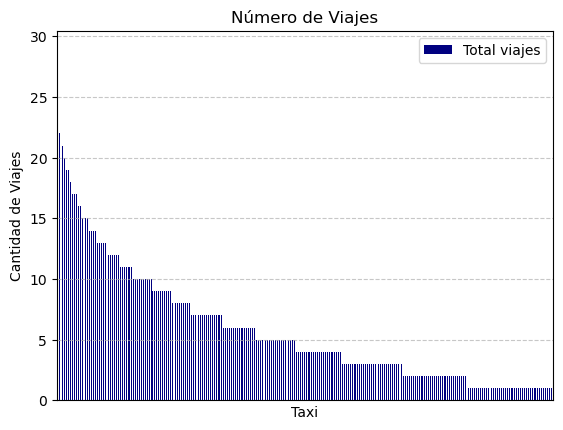

In [31]:
plt.figure()
num_viajes_df.plot(kind="bar", color="navy")
plt.title("Número de Viajes")
plt.xlabel("Taxi")
plt.ylabel("Cantidad de Viajes")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks([])
plt.show()

**Hipótesis**

Es posible que aquellos táxistas que tienen más tiempo, son lo que tienen más viajes, y aquellos con menos viajes son los taxistas que van iniciando

**Taxista con más viajes en el tiempo**

In [32]:
from pyspark.sql.functions import month, year, col

# Obtener el Taxi ID con más viajes
taxista_top1_viajes = num_viajes.first()["Taxi ID"]

# Filtrar el DataFrame para el taxi con más viajes
taxista_df_masviajes = df.filter(F.col("Taxi ID") == taxista_top1_viajes)

# Extraer el año y el mes de "Trip Start Timestamp" y contar los viajes por mes
trips_by_month = (
    taxista_df_masviajes.groupBy(
        year("Trip Start Timestamp").alias("Año"),
        month("Trip Start Timestamp").alias("Mes"),
    )
    .agg(F.count("Trip ID").alias("Total Viajes"))
    .orderBy("Año", "Mes")
)

In [33]:
trips_by_month_df = trips_by_month.toPandas()
trips_by_month_df["Dia"] = 1
trips_by_month_df["fecha"] = (
    trips_by_month_df["Año"].astype(str)
    + "-"
    + trips_by_month_df["Mes"].astype(str).str.zfill(2)
    + "-"
    + trips_by_month_df["Dia"].astype(str).str.zfill(2)
)

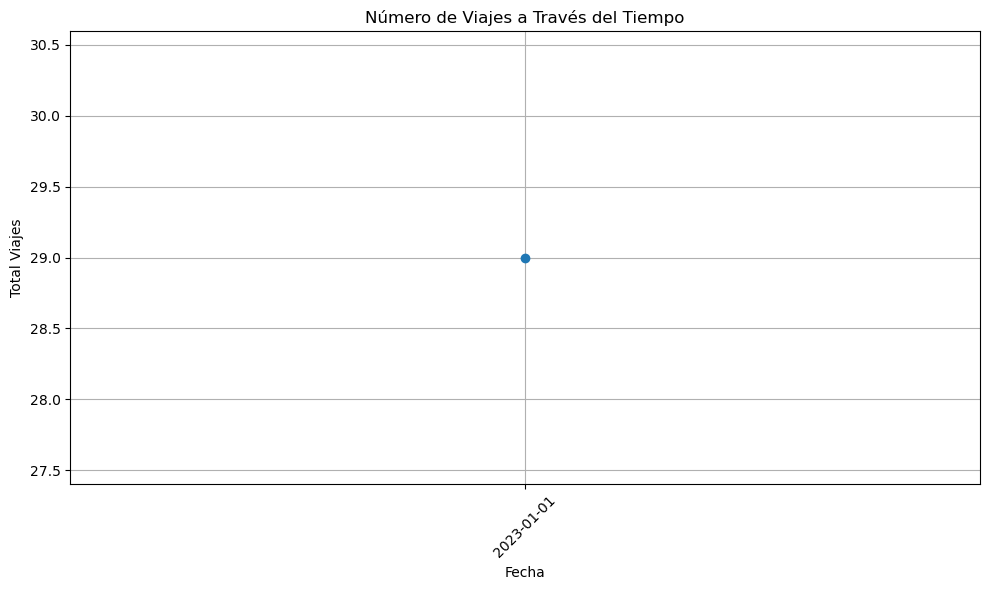

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(
    trips_by_month_df["fecha"],
    trips_by_month_df["Total Viajes"],
    marker="o",
    linestyle="-",
)
plt.title("Número de Viajes a Través del Tiempo")
plt.xlabel("Fecha")
plt.ylabel("Total Viajes")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

**Taxista con menos viajes en el tiempo**

In [35]:
# Obtener el Taxi ID con menos viajes
taxista_notop_viajes = num_viajes.orderBy("Total viajes", ascending=True).first()[
    "Taxi ID"
]
taxista_df_menosviajes = df.filter(F.col("Taxi ID") == taxista_notop_viajes)
trips_by_month = (
    taxista_df_menosviajes.groupBy(
        year("Trip Start Timestamp").alias("Año"),
        month("Trip Start Timestamp").alias("Mes"),
    )
    .agg(F.count("Trip ID").alias("Total Viajes"))
    .orderBy("Año", "Mes")
)

In [36]:
trips_by_month_df = trips_by_month.toPandas()
trips_by_month_df["Dia"] = 1
trips_by_month_df["fecha"] = (
    trips_by_month_df["Año"].astype(str)
    + "-"
    + trips_by_month_df["Mes"].astype(str).str.zfill(2)
    + "-"
    + trips_by_month_df["Dia"].astype(str).str.zfill(2)
)

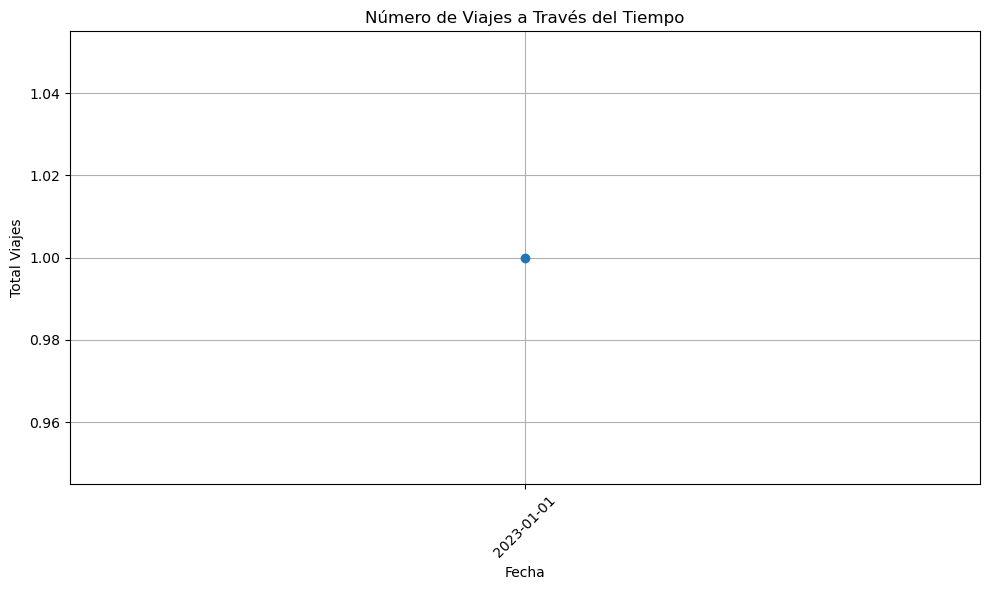

In [37]:
# Graficar

trips_by_month_df = trips_by_month_df.sort_values("fecha")

plt.figure(figsize=(10, 6))
plt.plot(
    trips_by_month_df["fecha"],
    trips_by_month_df["Total Viajes"],
    marker="o",
    linestyle="-",
)
plt.title("Número de Viajes a Través del Tiempo")
plt.xlabel("Fecha")
plt.ylabel("Total Viajes")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

Confirmamos que el taxista que tiene más viajes, lleva trabajando desde 2023, y el taxista con menos viajes solo trabajo un día. 

### ¿En qué áreas se registran más inicios/descensos de viajes?

Es posible que las zonas más demandadas sean aquellas con mayor cantidad concentraciónde personas, como aeropuertos o centro de la ciudad. 

In [38]:
top_5_pickup_areas = (
    df.groupBy("Pickup Community Area")
    .count()
    .orderBy("count", ascending=False)
    .limit(5)
)

# Mostrar los resultados
top_5_pickup_areas.show()

+---------------------+-----+
|Pickup Community Area|count|
+---------------------+-----+
|                    8| 2053|
|                   32| 1741|
|                   28| 1415|
|                   76| 1073|
|                 NULL|  579|
+---------------------+-----+



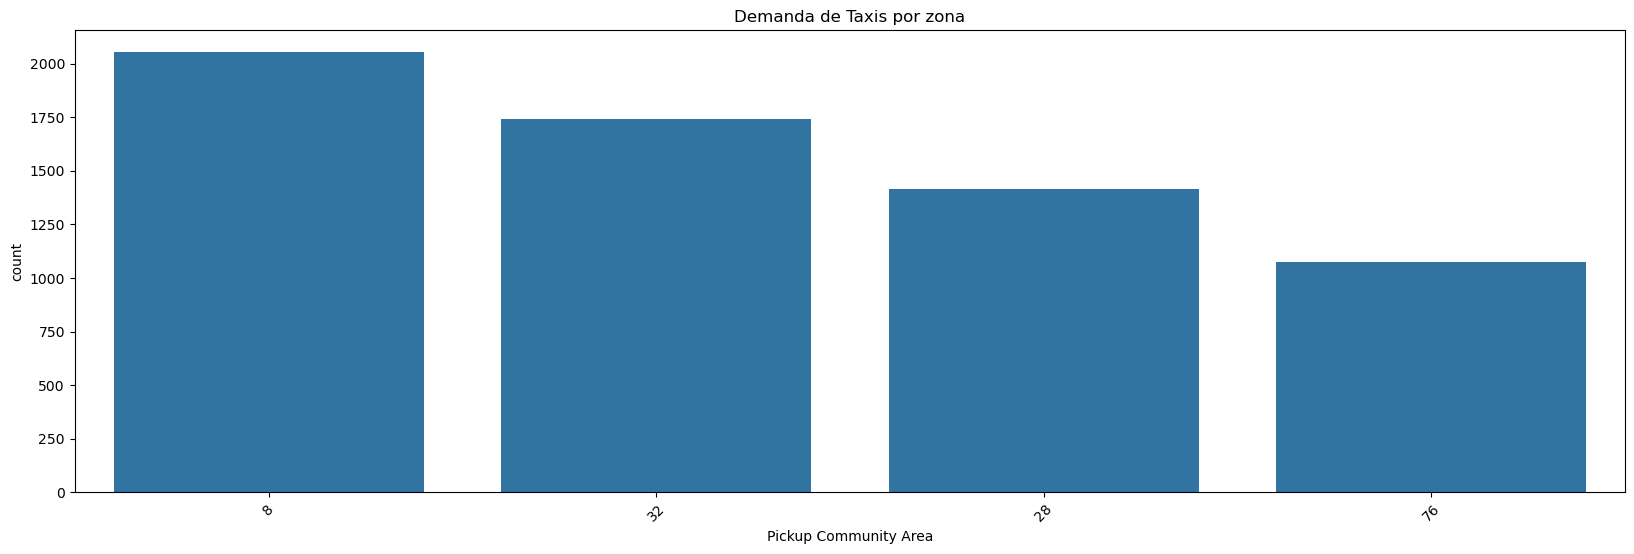

In [39]:
top_5_pickup_areas_df = top_5_pickup_areas.toPandas()

plt.figure(figsize=(20, 6))
sns.barplot(x="Pickup Community Area", y="count", data=top_5_pickup_areas_df)
plt.title("Demanda de Taxis por zona")
plt.xticks(rotation=45)
plt.show()

Las zonas con mayor zonas de **recolección** de pasajeros son: 
- 8 correspone a Near North que es parte del centro de Chicago
- 76 es O"Hare donde se ubica el Aeropuerto Internacional O"Hare
- 32 es Loop, que es parte del centro de Chicago
- 28 es Near West Side
- 56 es Garfield Ridge se ubica el Aeropuerto Internacional Midway

In [40]:
top_5_dropoff_areas = (
    df.filter(F.col("Dropoff Community Area").isNotNull())
    .groupBy("Dropoff Community Area")
    .count()
    .orderBy("count", ascending=False)
    .limit(5)
)

# Mostrar los resultados
top_5_dropoff_areas.show()

+----------------------+-----+
|Dropoff Community Area|count|
+----------------------+-----+
|                     8| 2138|
|                    32| 2120|
|                    28| 1163|
|                    76|  504|
|                     6|  359|
+----------------------+-----+



Las zonas de mayor **descenso** de pasajeros coincide con las zonas de mayor ascenso de pasajeros

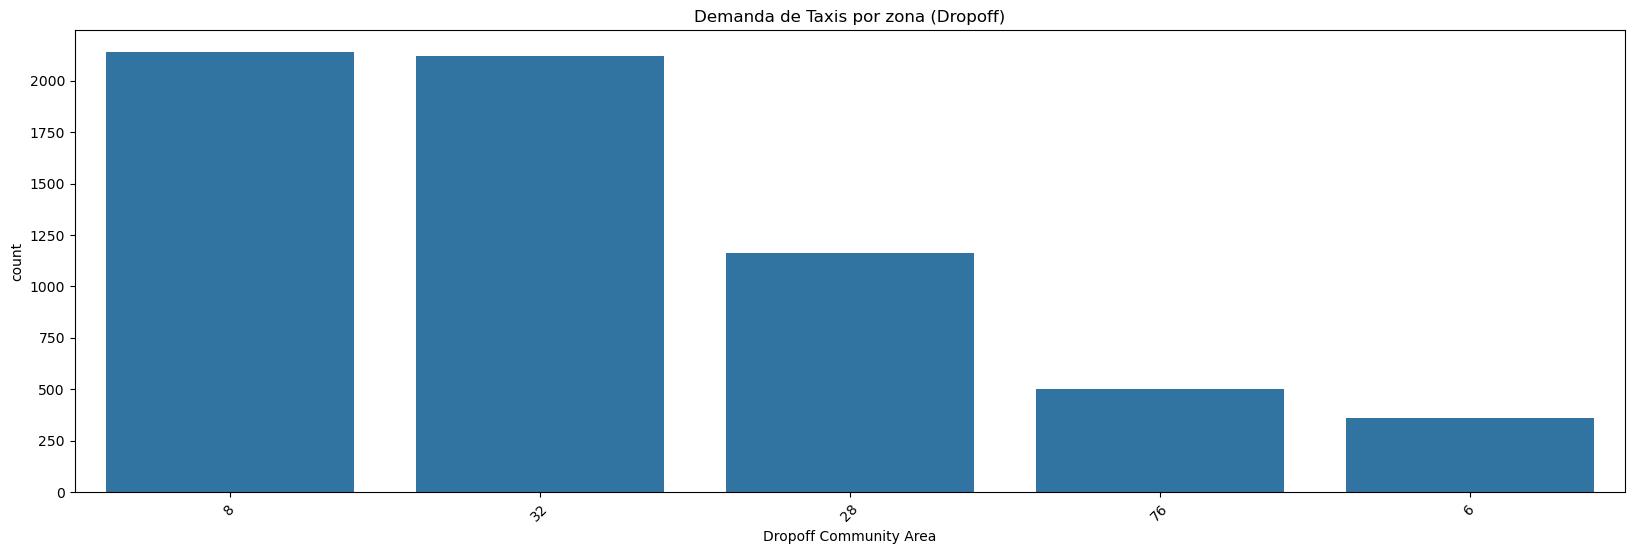

In [41]:
top_5_dropoff_areas_df = top_5_dropoff_areas.toPandas()

plt.figure(figsize=(20, 6))
sns.barplot(x="Dropoff Community Area", y="count", data=top_5_dropoff_areas_df)
plt.title("Demanda de Taxis por zona (Dropoff)")
plt.xticks(rotation=45)
plt.show()

# 4. Análisis de Outliers

### Duración del viaje

In [42]:
count_zeros = df.filter(F.col("Trip Seconds") == 0).count()

print(f"Total de ceros en Trip Seconds: {count_zeros}")

Total de ceros en Trip Seconds: 187


Hay viajes con valores igual a 0 en la duración del viaje, que son anómales.

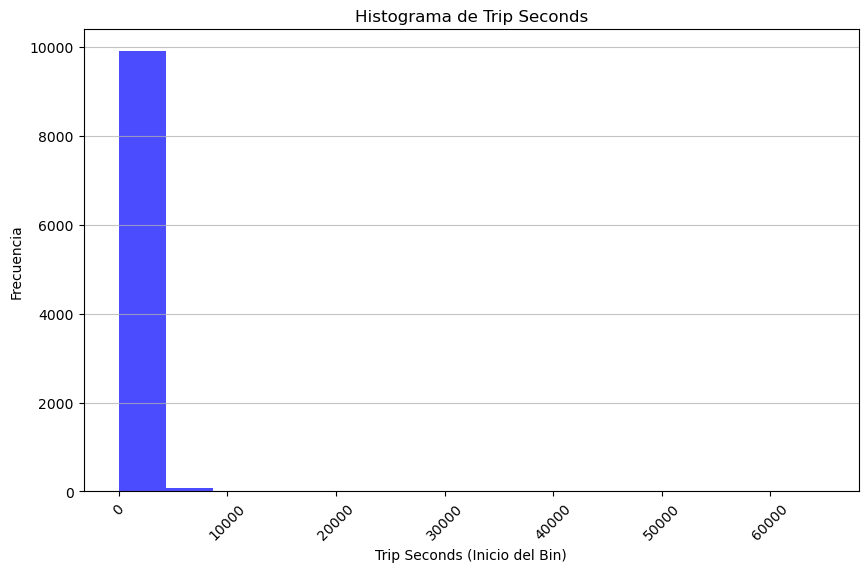

In [43]:
plot_histogram(df, "Trip Seconds", num_bins=15)

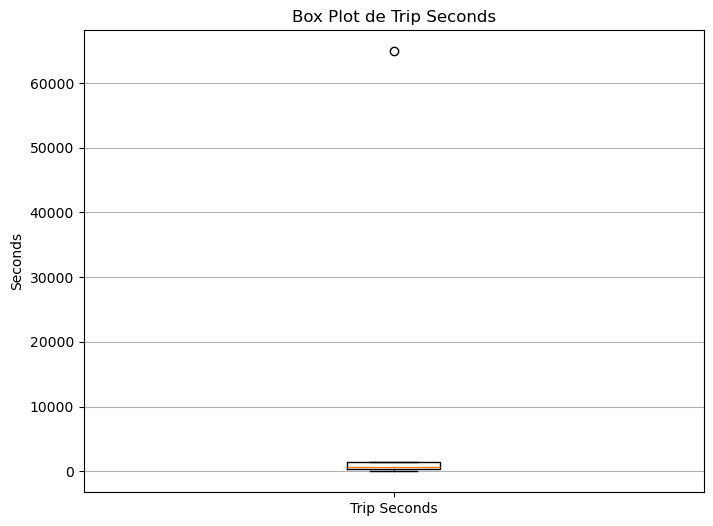

In [44]:
create_box_plot(df, "Trip Seconds")

In [45]:
trip_seconds_percentiles_df = calculate_trip_seconds_percentiles(df, "Trip Seconds")
percentile_99 = trip_seconds_percentiles_df[
    trip_seconds_percentiles_df["Percentiles"] == 0.99
]["Trip Seconds"].iloc[0]
print(f"El valor del percentil 99 para \"Trip Seconds\" es: {percentile_99:,}")

El valor del percentil 99 para "Trip Seconds" es: 64,893.0


**Filtrando para viajes válidos**

In [46]:
df = df.filter((F.col("Trip Seconds") > 0) & (F.col("Trip Seconds") < percentile_99))

### Fare, Tips, Tolls, Extras

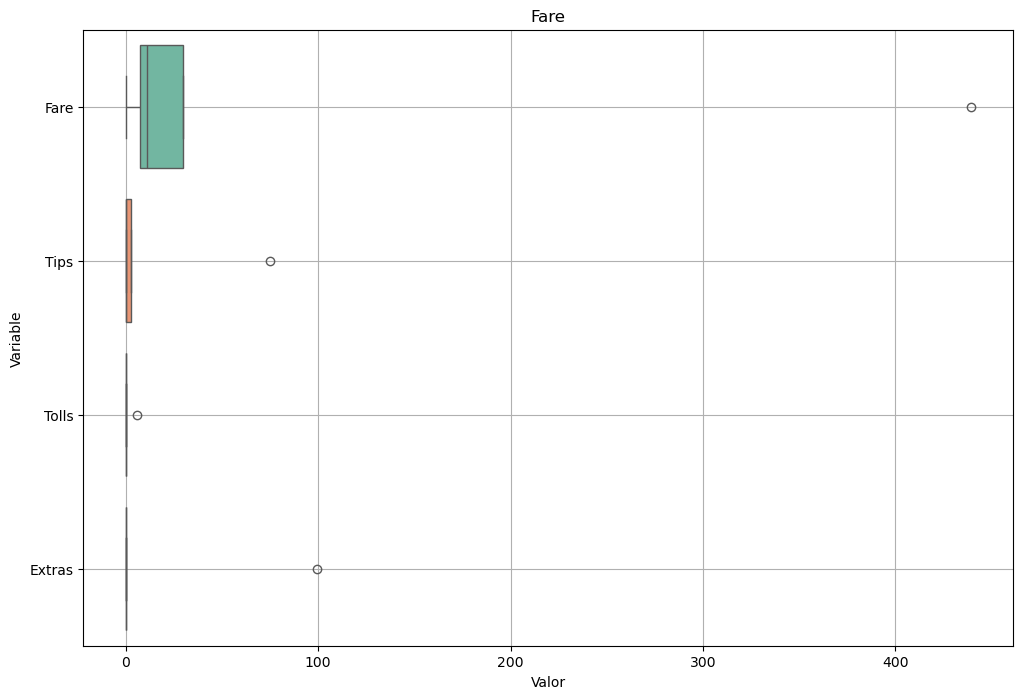

In [47]:
create_boxplot(df, ["Fare", "Tips", "Tolls", "Extras"], title="Fare")

In [48]:
results = []
for column in ["Fare", "Tips", "Tolls", "Extras"]:
    count_zeros = df.filter(df[column] == 0).count()
    total_count = df.count()
    percentage = (count_zeros / total_count) * 100 if total_count > 0 else 0
    results.append((column, count_zeros, percentage))

results_df = pd.DataFrame(results, columns=["feature", "count", "%"])

results_df

,feature,count,%
0,Fare,10,0.102030
1,Tips,5005,51.066218
2,Tolls,9787,99.857157
3,Extras,7532,76.849301


### TODO: Análisis de cantidad de ceros

### Fare (Tarifa)

In [49]:
_ = calculate_outliers(df, "Fare")

Cantidad de outliers: 132
Porcentaje de outliers: 1.35 %


Análisis de comportamiento para aquellos valores por debajo de la tarifa mínimca de $3.25

In [50]:
df[df["Fare"] < 3.25].describe().toPandas()

,summary,Trip ID,Taxi ID,Trip Seconds,Trip Miles,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,count,10,10,10,10,10,9,10,10,10,10,10,10,10,10,10,10,9,9,9
1,mean,None,None,1146.0,5.453999960422516,28.7,30.88888888888889,0.0,0.0,0.0,0.0,0.0,None,None,41.8745915122,-87.6703577933,None,41.88387912266666,-87.65607405055556,None
2,stddev,None,None,1119.2925344956866,6.089161984085778,23.471259020342305,23.93973916130063,0.0,0.0,0.0,0.0,0.0,None,None,0.05137314469932738,0.05057353114306187,None,0.0507987030949666,0.03126725026041317,None
3,min,1049944fe3c51be9feb6bb9d95d546b01a7a9d4c,1095c5432cb9cfd88296fb166e38d560936d4690801ddd...,1,0.0,19,24,0.0,0.0,0.0,0.0,0.0,Cash,Chicago Independents,41.769778059,-87.619710672,POINT (-87.6197106717 41.8950334495),41.80908443,-87.619710672,POINT (-87.6197106717 41.8950334495)
4,max,f1336d49059bb2e226dfdc0dc8b16a6ec35f9dfb,e1d51d08cb24e771a915f9058577f158307344815ca309...,3589,18.43,8,8,0.0,0.0,0.0,0.0,0.0,Cash,Globe Taxi,41.927260956,-87.765501609,POINT (-87.7655016086 41.9272609555),41.9867118,-87.7172201,POINT (-87.7172201 41.8601900192)


### TODO: Análisis de Fare menor a 3.25

Se acotará el dataFrame para limitar la tarifa a partir de $3.25 para ajustar los cobros a la tarifa base.

In [51]:
df = df[df["Fare"] >= 3.25]

### Análisis con unidad muestral taxi

In [52]:
lower_bound, upper_bound = calculate_outliers(df, "Fare")
fare_outliers = df.filter((F.col("Fare") < lower_bound) | (F.col("Fare") > upper_bound))
fare_outliers_df = fare_outliers.describe().toPandas().round(2)
fare_outliers_df

Cantidad de outliers: 132
Porcentaje de outliers: 1.35 %


,summary,Trip ID,Taxi ID,Trip Seconds,Trip Miles,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,count,132,132,132,132,94,62,132,132,132,132,132,132,132,94,94,94,62,62,62
1,mean,None,None,3707.030303030303,26.046287842066675,55.45744680851064,47.403225806451616,84.41643954768325,6.5054546052759346,0.04431818109570128,10.149621212121213,101.31659082932906,None,None,41.89273408409576,-87.77183211976593,None,41.87293798517743,-87.71744655383871,None
2,stddev,None,None,5969.162812832099,24.46546376143441,24.72979348648583,25.34642580126427,45.88710574391443,12.031910871665072,0.5091771353697466,18.28106630783904,52.242896392116776,None,None,0.10472590962376108,0.1338089574793194,None,0.10337458530767515,0.1259293576038386,None
3,min,01c1f7d44dbb70226fba9fe7944d45ed4d28247d,02829774801528933cdce279a9ebc9dbab805ccd5e5b52...,2,0.0,1,1,63.0,0.0,0.0,0.0,63.25,Cash,5 Star Taxi,41.660136051,-87.551428197,POINT (-87.551428197 41.7412427285),41.689729914,-87.572717134,POINT (-87.5727171342 41.7296764229)
4,max,ff1e338ed719b4d4aae4c610d0c082fe9cd2b8b3,ff60dabe17243a25435dcaf430a8b31615374bfc6be841...,62596,192.44,8,8,439.25,75.0,5.85,72.0,447.75,Unknown,U Taxicab,42.009622881,-87.913624596,POINT (-87.913624596 41.9802643146),42.009622881,-87.913624596,POINT (-87.913624596 41.9802643146)


In [53]:
# Agrupa por "Taxi ID" y suma la cantidad de "Fare" en outliers
conteo_outliers_por_taxista = fare_outliers.groupBy("Taxi ID").agg(
    F.sum("Fare").alias("Total Fare")
)

# Obtener el "Taxi ID" con la suma máxima de "Fare"
taxista_con_mas_outliers = conteo_outliers_por_taxista.orderBy(
    F.desc("Total Fare")
).first()["Taxi ID"]

print(f"El Taxi ID con la mayor cantidad de outliers es: {taxista_con_mas_outliers}")

El Taxi ID con la mayor cantidad de outliers es: 48ecd6bfab845390f0d93f88187c67aca1fc91445dd0865f3b08825506917032511ace2686bbcf061044a3b56e501ea409457d38dcb30c954665306d55ced8c6


<Figure size 1200x600 with 0 Axes>

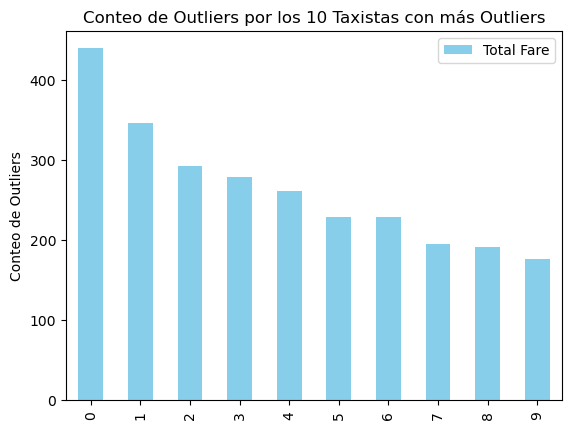

In [54]:
# Obtener los 10 taxistas con más outliers
top_10_taxistas = (
    conteo_outliers_por_taxista.orderBy(F.desc("Total Fare")).limit(10).toPandas()
)

fig = plt.figure(figsize=(12, 6))
top_10_taxistas.plot(kind="bar", color="skyblue")

plt.title("Conteo de Outliers por los 10 Taxistas con más Outliers")
plt.ylabel("Conteo de Outliers")
plt.xticks(rotation=90)

plt.show()

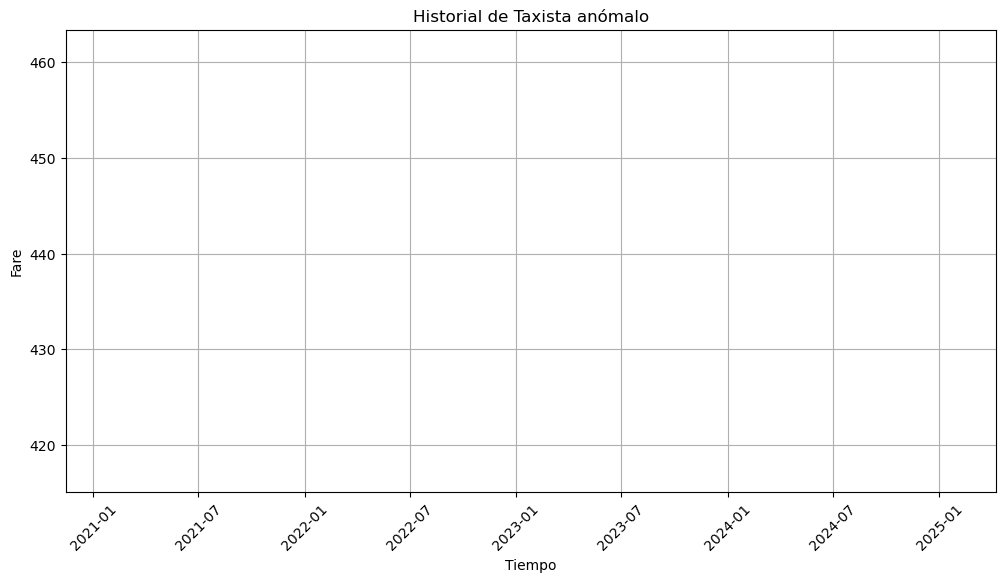

In [55]:
# Filtrar el DataFrame para obtener las filas del taxista con más outliers
taxista_outliers_df = df.filter(F.col("Taxi ID") == taxista_con_mas_outliers).toPandas()
taxista_outliers_df = taxista_outliers_df.sort_values("Trip Start Timestamp")

plt.figure(figsize=(12, 6))
plt.plot(taxista_outliers_df["Trip Start Timestamp"], taxista_outliers_df["Fare"])
plt.title("Historial de Taxista anómalo")
plt.xlabel("Tiempo")
plt.ylabel("Fare")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### TODO: Falta análisis 

In [56]:
max_fare = fare_outliers.agg(F.max("Fare")).first()[0]
print(f"El valor máximo de Fare en los outliers es: {max_fare}")

El valor máximo de Fare en los outliers es: 439.25


In [57]:
# Filtrar el DataFrame para obtener los registros donde "Fare" es mayor o igual a max_fare
anomalies_df = df.filter(F.col("Fare") >= max_fare)

# Obtener el "Taxi ID" y "Trip ID" de la primera fila del DataFrame filtrado
taxi_anomalo = anomalies_df.select("Taxi ID").first()["Taxi ID"]
viaje_anomalo = anomalies_df.select("Trip ID").first()["Trip ID"]

# Imprimir el "Taxi ID" anómalo
print(f"El Taxi ID anómalo es: {taxi_anomalo}")

El Taxi ID anómalo es: 48ecd6bfab845390f0d93f88187c67aca1fc91445dd0865f3b08825506917032511ace2686bbcf061044a3b56e501ea409457d38dcb30c954665306d55ced8c6


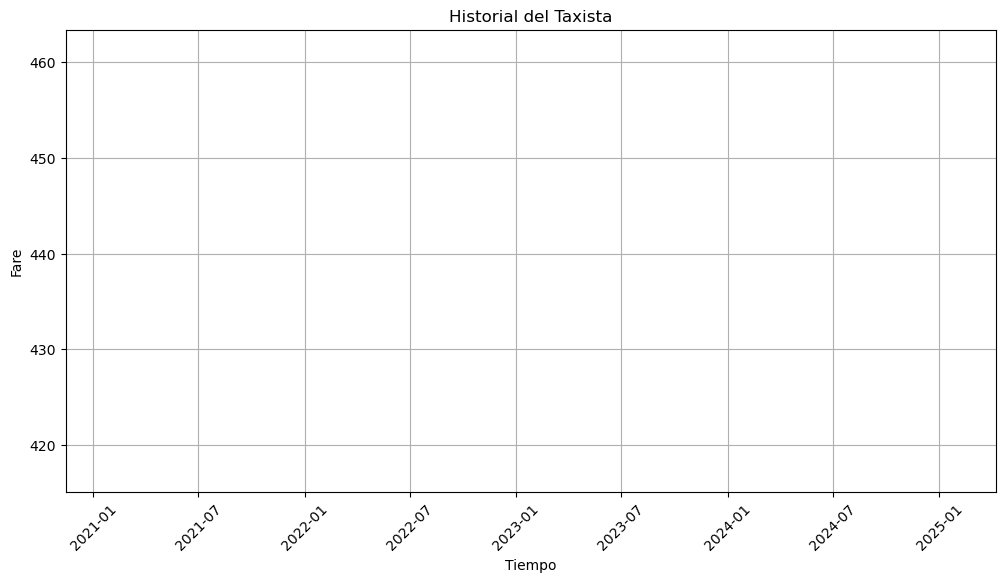

In [58]:
# Filtrar el DataFrame para obtener los datos del taxista anómalo
taxista_data = df.filter(F.col("Taxi ID") == taxi_anomalo)

# Convertir las columnas a Pandas para poder graficar
taxista_data_pd = taxista_data.toPandas()
taxista_data_pd = taxista_data_pd.sort_values("Trip Start Timestamp")

# Crear la figura y el gráfico
plt.figure(figsize=(12, 6))
plt.plot(taxista_data_pd["Trip Start Timestamp"], taxista_data_pd["Fare"])

# Configurar el título y las etiquetas
plt.title("Historial del Taxista")
plt.xlabel("Tiempo")
plt.ylabel("Fare")
plt.grid(True)
plt.xticks(rotation=45)

# Mostrar la gráfica
plt.show()

In [59]:
trip_id_a_eliminar = viaje_anomalo
df = df[df["Trip ID"] != trip_id_a_eliminar]

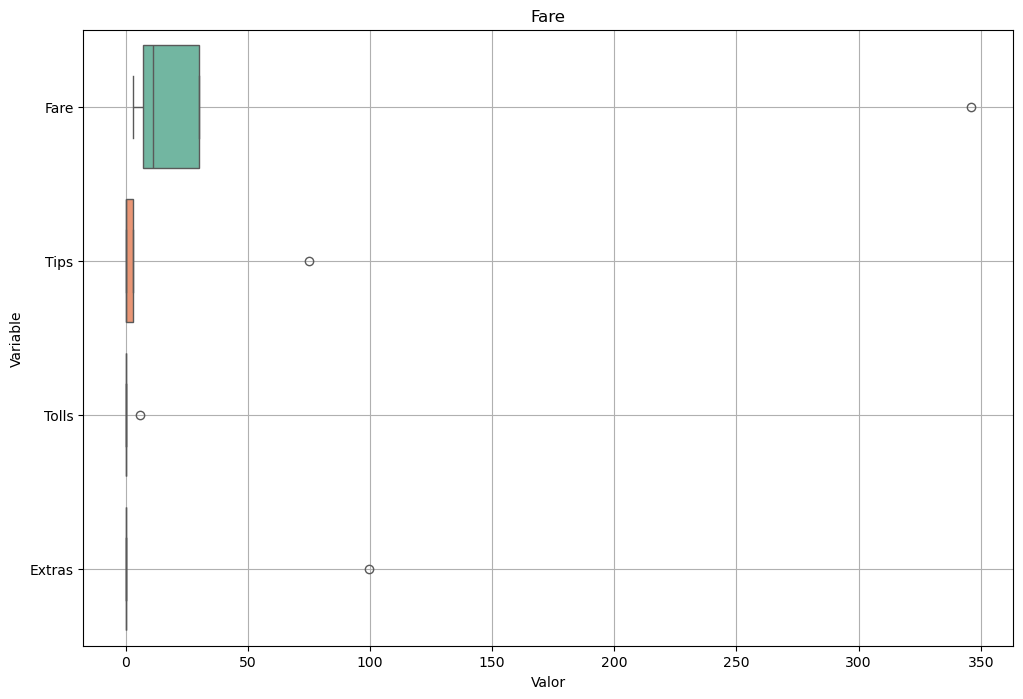

In [60]:
create_boxplot(df, ["Fare", "Tips", "Tolls", "Extras"], title="Fare")

In [61]:
descripcion = df.select("Fare").summary()
descripcion.show()

+-------+------------------+
|summary|              Fare|
+-------+------------------+
|  count|              9790|
|   mean|19.181349338184702|
| stddev|16.031611444081005|
|    min|              3.25|
|    25%|              7.25|
|    50%|             11.25|
|    75%|              30.0|
|    max|             346.0|
+-------+------------------+



In [62]:
calculate_and_print_percentiles(df, "Fare")

Percentiles específicos de 'Fare':
Percentil 0.9700: 47.25
Percentil 0.9800: 50.0
Percentil 0.9997: 346.0
Percentil 0.9998: 346.0
Percentil 0.9999: 346.0


### TODO: Justificar por que dejar Fare < a 200

In [63]:
df = df.filter(F.col("Fare") < 200)

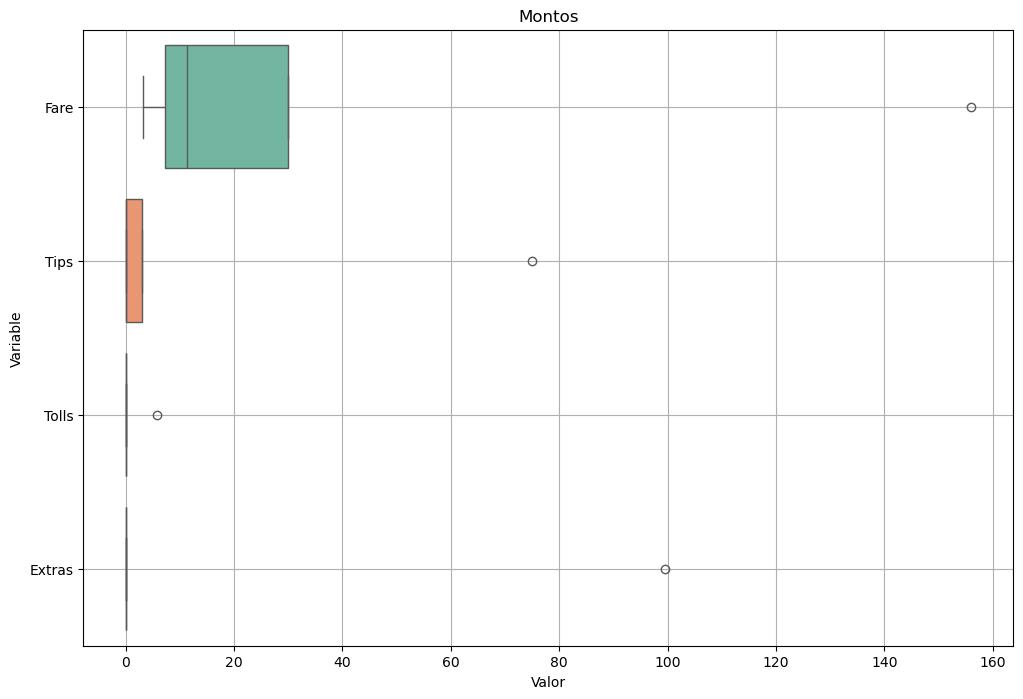

In [64]:
create_boxplot(df, ["Fare", "Tips", "Tolls", "Extras"], title="Montos")

### Peaje (Tolls)

In [65]:
calculate_and_print_percentiles(df, "Tolls")

Percentiles específicos de 'Tolls':
Percentil 0.9700: 0.0
Percentil 0.9800: 0.0
Percentil 0.9997: 5.849999904632568
Percentil 0.9998: 5.849999904632568
Percentil 0.9999: 5.849999904632568


In [66]:
count = df.filter(df["Tolls"] >= 100).count()
print(f"El número de filas con 'Tolls' >= 100 es: {count}")

El número de filas con 'Tolls' >= 100 es: 0


El monto máximo que se puede pagar en 'Tolls' es 100, por lo que se filtrarán aquellos registros con un 'Toll' mayor que $100
https://ua.getipass.com/trip-calculator

In [67]:
df = df.filter(df['Tolls'] < 100)

### Extras

In [68]:
calculate_and_print_percentiles(df, "Extras", [0.99, 0.99992, 0.99994, 0.99996, 0.99998, 0.99999])

Percentiles específicos de 'Extras':
Percentil 0.9900: 99.5
Percentil 0.9999: 99.5
Percentil 0.9999: 99.5
Percentil 1.0000: 99.5
Percentil 1.0000: 99.5
Percentil 1.0000: 99.5


En el caso de los extras, al considear la mayor cantidad de pasajeros y gastos de limpieza, no debería exceder arriba de $100 dólares

In [69]:
df = df.filter(df['Extras'] < 100)

### Revisión final de Outliers

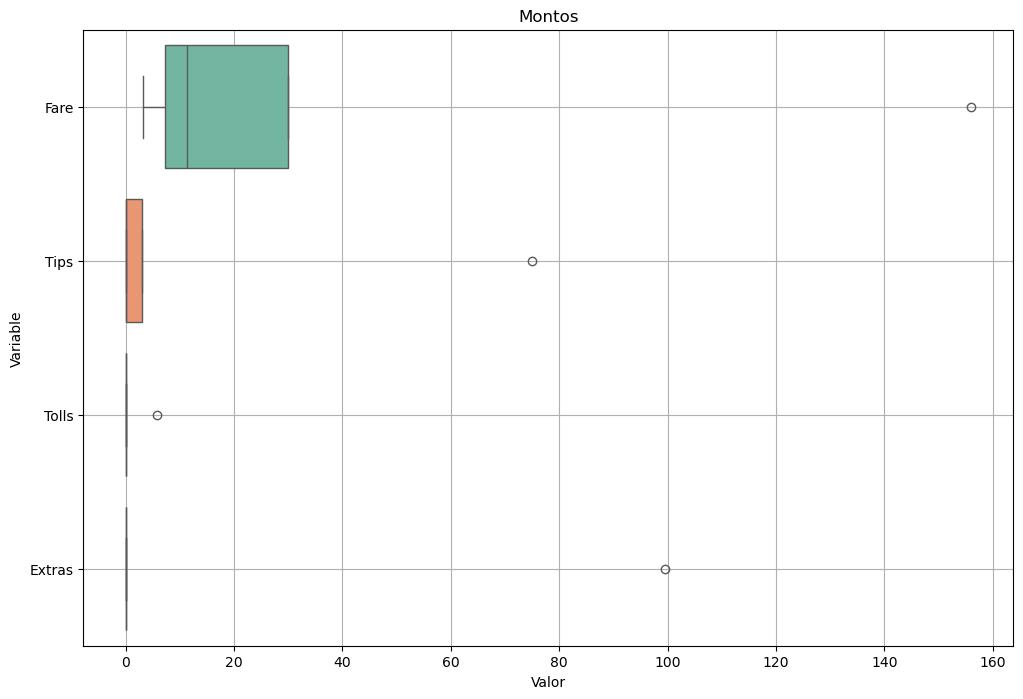

In [70]:
create_boxplot(df, ["Fare", "Tips", "Tolls", "Extras"], title="Montos")

# 5. Análisis de Correlación

In [71]:
# Combinar columnas en un vector usando VectorAssembler
vector_col = "features"
columns = ['Trip Seconds', 'Trip Miles', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total']
assembler = VectorAssembler(inputCols=columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# Calcular la matriz de correlación
correlation_matrix = Correlation.corr(df_vector, vector_col).head()[0]

# Convertir la matriz a un formato legible (numpy o pandas)
corr_array = correlation_matrix.toArray()
corr_df = pd.DataFrame(corr_array, columns=columns, index=columns)

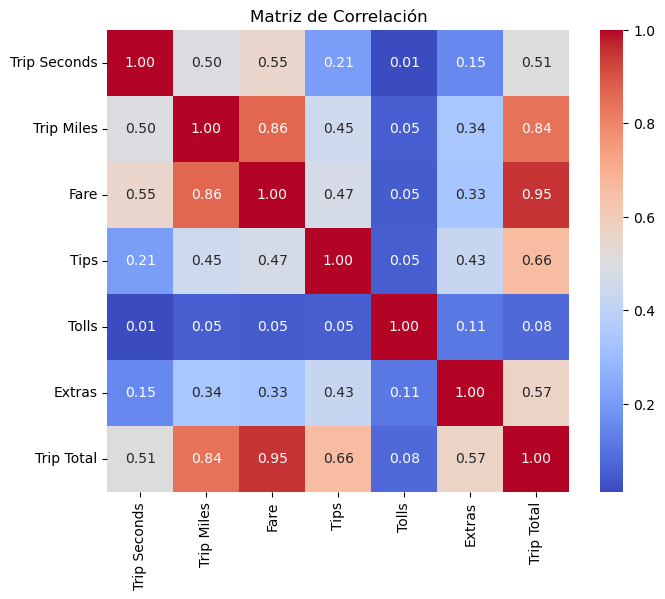

In [72]:
plot_correlation_matrix(corr_df)

### TODO: Análisis de correlación

# 6. Imputación de datos

**Trip Miles**

Se tiene la hipótesis de que la mayoría de los datos para la variable 'Trip Miles' en cero los podríamos recuperar calculando la distancia entre **(Pickup Centroid Latitud-Pickup Centroid Longitude)** y **(Dropoff Centroid Latitude-Dropoff Centroid Longitude)**.

In [73]:
missings_df[missings_df["feature"] == "Trip Miles"]

,feature,count,%
0,Trip Miles,0,0.0


In [74]:
trip_miles_zero = df.filter(col("Trip Miles") == 0)

# Filtrar los datos donde las columnas de ubicación no son NaN
filtered_data = trip_miles_zero.filter(
    col("Pickup Centroid Latitude").isNotNull() &
    col("Pickup Centroid Longitude").isNotNull() &
    col("Dropoff Centroid Latitude").isNotNull() &
    col("Dropoff Centroid Longitude").isNotNull()
)

# Contar la cantidad de registros que cumplen con las condiciones
count_records = filtered_data.count()
print(f"Cantidad de registros con 'Trip Miles' igual a cero y con valores diferentes a NaN en ubicaciones: {count_records}")

Cantidad de registros con 'Trip Miles' igual a cero y con valores diferentes a NaN en ubicaciones: 764


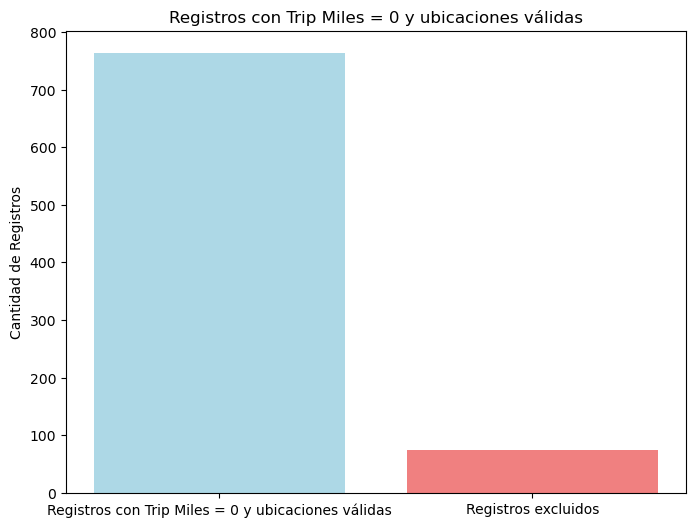

In [75]:
categorias = ['Registros con Trip Miles = 0 y ubicaciones válidas', 'Registros excluidos']

# Cantidad de registros que cumplen con las condiciones y registros excluidos
trip_miles_zero_count = trip_miles_zero.count()
cantidad_registros = [count_records, trip_miles_zero_count - count_records]

# Colores para las barras
colores = ['lightblue', 'lightcoral']

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(categorias, cantidad_registros, color=colores)
plt.title('Registros con Trip Miles = 0 y ubicaciones válidas')
plt.ylabel('Cantidad de Registros')
plt.show()

### TODO: Análisis sobre Trip Miles igual a 0

In [76]:
# !pip install geopy

In [77]:
from pyspark.sql.functions import col, when, udf
from geopy.distance import great_circle as GRC

# Definir una función para calcular la distancia
def calculate_distance(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    try:
        # Verificar si alguna coordenada es nula
        if any(coord is None for coord in [pickup_lat, pickup_lon, dropoff_lat, dropoff_lon]):
            return 0.0
        # Calcular la distancia
        pickup_coords = (pickup_lat, pickup_lon)
        dropoff_coords = (dropoff_lat, dropoff_lon)
        return GRC(pickup_coords, dropoff_coords).miles
    except Exception:
        return 0.0

# Registrar la función como una UDF (User-Defined Function)
calculate_distance_udf = udf(calculate_distance)

# Crear una nueva columna con los valores de 'Trip Miles' imputados
# df = df.withColumn(
#     "Trip Miles",
#     when(
#         col("Trip Miles") == 0,
#         calculate_distance_udf(
#             col("Pickup Centroid Latitude"),
#             col("Pickup Centroid Longitude"),
#             col("Dropoff Centroid Latitude"),
#             col("Dropoff Centroid Longitude")
#         )
#     ).otherwise(col("Trip Miles"))
# )


Por dificultades para usar geopy en los nodos (se tiene que instalar en cada uno) removeremos aquellos registros de Trip Miles con un valor igual a cero.

In [78]:
df = df.filter(F.col("Trip Miles") != 0)

# 7. Ingeniería de variables

In [79]:
# Recorrido en minutos
df = df.withColumn("Trip Minutes", F.col("Trip Seconds") / 60)

# Recorrido en horas
df = df.withColumn("Trip Hours", F.col("Trip Minutes") / 60)

# Recorrido en kilómetros
df = df.withColumn("Trip Kilometers", F.col("Trip Miles") * 1.60934)

# Velocidad promedio del taxi
df = df.withColumn("Trip Speed", F.col("Trip Kilometers") / F.col("Trip Hours"))

# Tasa de propinas
df = df.withColumn("Tips Ratio", F.col("Tips") / F.col("Trip Total"))

In [80]:
df.cache().count()

8948

Creamos una variable binaria que nos dice si el viaje ha sido iniciado en el aeropuerto, pues esto supondría un costo extra de 4 dólares.

In [86]:
df = df.withColumn(
    'Is Airport',
    F.when((F.col('Pickup Community Area') == 76) | (F.col('Pickup Community Area') == 56), 1)
    .otherwise(0)
)

get_value_proportions(df, "Payment Type").show()

+------------+-----+-------------------+
|Payment Type|count|         Proportion|
+------------+-----+-------------------+
| Credit Card| 3135| 0.3503576218149307|
|      Mobile| 1384| 0.1546714349575324|
|        Cash| 2478|0.27693339293696917|
|      Others| 1951|0.21803755029056773|
+------------+-----+-------------------+



In [87]:
mapping_dict = {'Unknown': 'Others', 'No Charge': 'Others', 'Dispute': 'Others', 'Prcard': 'Others'}

# Aplicar el mapeo a la columna 'Payment Type'
for key, value in mapping_dict.items():
    df = df.withColumn('Payment Type', F.when(F.col('Payment Type') == key, value).otherwise(F.col('Payment Type')))
    
get_value_proportions(df, "Payment Type").show()

+------------+-----+-------------------+
|Payment Type|count|         Proportion|
+------------+-----+-------------------+
| Credit Card| 3135| 0.3503576218149307|
|      Mobile| 1384| 0.1546714349575324|
|        Cash| 2478|0.27693339293696917|
|      Others| 1951|0.21803755029056773|
+------------+-----+-------------------+



**Generando variables Dummy**

In [88]:
payment_type_dummies = df.groupBy('Payment Type').count().withColumn('dummy', F.lit(1))

# Convertir el resultado en formato de variables dummy
dummies = payment_type_dummies.select(
    'Payment Type',
    *[F.when(F.col('Payment Type') == payment_type, 1).otherwise(0).alias(f'Payment_Type_{payment_type}') for payment_type in payment_type_dummies.select('Payment Type').rdd.flatMap(lambda x: x).collect()]
)

# Concatenar las variables dummy al DataFrame original
df = df.join(dummies, on='Payment Type', how='left')

# Eliminar la columna original 'Payment Type' si es necesario
df = df.drop('Payment Type')

df.limit(5).toPandas()


,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,Trip Minutes,Trip Hours,Trip Kilometers,Trip Speed,Tips Ratio,Is Airport,Payment_Type_Credit Card,Payment_Type_Mobile,Payment_Type_Cash,Payment_Type_Others
0,9cf79169a830bd5b3bafbd2eefc3d40e625882ff,1a03ec6dac498d139ef048e17bc38bb4b1ca9ad0fc4edb...,2023-01-26 14:00:00,2023-01-26 14:30:00,1736,9.21,41,28,27.0,0.00,0.0,2.0,29.000000,City Service,41.794090253,-87.592310855,POINT (-87.592310855 41.794090253),41.874005383,-87.66351755,POINT (-87.6635175498 41.874005383),28.933333,0.482222,14.822021,30.736911,0.000000,0,0,0,1,0
1,6f9a2d2699563fb9260a85dd64f6975856313f03,051db8af96f62880bd5b9970fe0cdb3c0ef257675696bd...,2023-01-26 13:30:00,2023-01-26 13:45:00,1521,13.13,56,8,34.5,7.90,0.0,4.5,47.400002,Star North Taxi Management Llc,41.785998518,-87.750934289,POINT (-87.7509342894 41.785998518),41.892507781,-87.626214906,POINT (-87.6262149064 41.8925077809),25.350000,0.422500,21.130634,50.013336,0.166667,1,1,0,0,0
2,32f82f28dfc98c5c37b582fb99c8184ff0b599e5,0aba795cd29b34ff868043bc923a341f37c4f6d7afabe4...,2023-01-25 21:45:00,2023-01-25 22:15:00,1080,0.40,8,39,21.5,5.50,0.0,0.0,27.000000,Taxi Affiliation Services,41.899602111,-87.633308037,POINT (-87.6333080367 41.899602111),41.808916283,-87.596183344,POINT (-87.5961833442 41.8089162826),18.000000,0.300000,0.643736,2.145787,0.203704,0,1,0,0,0
3,7fda0b5b20aea8d753f2c6ba5ea2e2435f59832e,f80bb6e887a18028617ef0e0861429d12762cfd858bcbc...,2023-01-26 09:30:00,2023-01-26 09:45:00,382,1.04,8,32,10.0,2.45,0.0,0.0,12.450000,City Service,41.890922026,-87.618868355,POINT (-87.6188683546 41.8909220259),41.880994471,-87.632746489,POINT (-87.6327464887 41.8809944707),6.366667,0.106111,1.673714,15.773217,0.196787,0,0,1,0,0
4,f0c75f4eb7c0820741fb47b9ad6990124c263c7e,1ba56b296b0d930b10a926807d5c67ff0f2ff5005dfb03...,2023-01-26 14:00:00,2023-01-26 14:15:00,540,1.57,8,8,8.0,8.00,0.0,0.0,16.500000,Star North Taxi Management Llc,41.892042136,-87.63186395,POINT (-87.6318639497 41.8920421365),41.898331794,-87.620762865,POINT (-87.6207628651 41.8983317935),9.000000,0.150000,2.526664,16.844426,0.484848,0,1,0,0,0


**Selección de características para usar en la ventana de tiempo**

In [89]:
columnas_seleccionadas = ['Trip ID', 'Taxi ID', 'Is Airport', 'Trip Start Timestamp', 'Trip Speed', 
                          'Tips Ratio', 'Trip Seconds', 'Trip Kilometers', 'Fare', 'Tips', 
                          'Tolls', 'Extras', 'Payment_Type_Cash', 'Payment_Type_Credit Card', 
                          'Payment_Type_Mobile', 'Payment_Type_Others']


df = df.select(*columnas_seleccionadas)

### TODO: Refrasear 

Se ordena los datos con respecto al tiempo y posteriormente se crea una función para generar etiquetas de las semanas consecutivas de nuestro dataset. Esto con la finalidad que posteriormente se agrupen por semana.

In [90]:
df = df.orderBy('Trip Start Timestamp')

# Encontrar la fecha de inicio y fin del conjunto de datos
fecha_inicio = df.select(F.min('Trip Start Timestamp')).first()[0]
fecha_fin = df.select(F.max('Trip Start Timestamp')).first()[0]

# Crear una función para asignar etiquetas de semana consecutivas
def assign_week_label(date):
    # Diferencia en semanas entre la fecha dada y la fecha de inicio
    week_number = (date - fecha_inicio).days // 7 + 1
    return week_number

# Registrar la función como UDF
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
assign_week_udf = udf(assign_week_label, IntegerType())

# Agregar una columna 'Week' con las etiquetas de semana consecutivas
df = df.withColumn('Week', assign_week_udf(F.col('Trip Start Timestamp')))

# Agregar una columna 'Trips' con el valor 1
df = df.withColumn('Trips', F.lit(1))

In [91]:
# Agrupar por 'Taxi ID' y 'Week', calcular algunas estadísticas para cada grupo
agrupado_por_taxi_semana = df.groupBy('Taxi ID', 'Week').agg(
    F.sum('Trips').alias('Total_Trips'),
    F.sum('Is Airport').alias('Total_Is_Airport'),
    F.mean('Trip Speed').alias('Avg_Trip_Speed'),
    F.mean('Tips Ratio').alias('Avg_Tips_Ratio'),
    F.sum('Trip Seconds').alias('Total_Trip_Seconds'),
    F.sum('Trip Kilometers').alias('Total_Trip_Kilometers'),
    F.sum('Fare').alias('Total_Fare'),
    F.sum('Tips').alias('Total_Tips'),
    F.sum('Tolls').alias('Total_Tolls'),
    F.sum('Extras').alias('Total_Extras'),
    F.sum('Payment_Type_Cash').alias('Total_Payment_Type_Cash'),
    F.sum('Payment_Type_Credit Card').alias('Total_Payment_Type_Credit_Card'),
    F.sum('Payment_Type_Mobile').alias('Total_Payment_Type_Mobile'),
    F.sum('Payment_Type_Others').alias('Total_Payment_Type_Others')
)

agrupado_por_taxi_semana = agrupado_por_taxi_semana.orderBy(['Taxi ID', 'Week'])

# Mostrar el resultado del agrupamiento
agrupado_por_taxi_semana.limit(5).toPandas()

,Taxi ID,Week,Total_Trips,Total_Is_Airport,Avg_Trip_Speed,Avg_Tips_Ratio,Total_Trip_Seconds,Total_Trip_Kilometers,Total_Fare,Total_Tips,Total_Tolls,Total_Extras,Total_Payment_Type_Cash,Total_Payment_Type_Credit_Card,Total_Payment_Type_Mobile,Total_Payment_Type_Others
0,0041f8f0c91881c1e1913f2548522495fe3c4c719aa67f...,1,9,0,1.946001,0.033543,8220,4.667086,154.00,4.00,0.0,3.0,1,2,0,6
1,00752524a4118a162dce62ff49c0eb0f79530d9e0ecb5a...,1,1,1,60.695108,0.105899,1260,21.243288,33.50,4.56,0.0,5.0,0,1,0,0
2,0083fcde0fb490b4ec424c63d1d750378f6ad11154d1d4...,1,5,1,1.355747,0.000000,4920,2.253076,82.25,0.00,0.0,4.0,3,0,0,2
3,008dda45db57cb6daa679a86ce8c8149ddc05446d545b1...,1,15,0,25.763108,0.084429,8940,80.788869,172.25,16.50,0.0,1.0,7,6,0,2
4,00aeef49089b36ed668920fac1119a26fb25d1b48102a4...,1,3,2,3.295488,0.169541,4560,4.023350,113.00,27.45,0.0,21.5,0,3,0,0


In [92]:
%%time
df_pivot = agrupado_por_taxi_semana.groupBy('Taxi ID').pivot('Week').agg(F.sum('Total_Fare'))

# Rellenar valores nulos con 0
df_pivot = df_pivot.na.fill(0)

# Renombrar columnas para que tengan el formato deseado
new_column_names = ['Taxi ID'] + [f'W{int(col)}' for col in df_pivot.columns[1:]]
df_pivot = df_pivot.toDF(*new_column_names)

# Mostrar el resultado
df_pivot.limit(5).toPandas()

,Taxi ID,W1
0,7da8dfbf5db7bed94dd92856d29697c070590f703b0b29...,49.25
1,6607f4be1b8737ffe33ac1f71d10d1132541d86cd00c1d...,420.75
2,beb0579501b2745e10d12af72f99864d506abb7c5de1eb...,31.50
3,e39f9fb04c45fac83b35fbc9c36b68ba97cdf877dd76fd...,68.50
4,cc474a035d6471f8bf8cef75b0c528e72b7f871e9bb029...,65.50
